In [145]:
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast
import cv2
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import segmentation_models_pytorch as smp
#import cc3d
from torch.utils.data import Dataset, DataLoader

In [146]:
class CFG:
# ============== model CFG =============
    model_name = 'Unet'
    #backbone = 'efficientnet-b0'
    backbone = 'se_resnet50'

    in_chans = 5 # 65
    # ============== training CFG =============
    image_size = 256
    input_size=256
    tile_size = image_size
    stride = tile_size // 2
    drop_egde_pixel=0
    
    target_size = 1
    # ============== fold =============
    valid_id = 1
    batch=64
    th_percentile = 0.002#0.005
    model_path=["./models/2023-12-10-baseline-v0/se_resnet50_9_loss0.01_score0.76_val_loss0.01_val_scorenan.pt"]

In [147]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.CFG = CFG
        self.encoder = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output[:,0]#.sigmoid()


def build_model(weight=None):
    from dotenv import load_dotenv
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model

In [148]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 1'
    return rle

def load_img(paths):
    output = []
    for path in paths:
        if path is None:
            output.append(None)
            continue
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = img.astype('float32') # original is uint16
        output.append(img)
    shape=[x.shape for x in output if x is not None][0]
    for i in range(len(output)):
        if output[i] is None:
            output[i] = tc.randn(shape)
    output=np.stack(output, axis=0)
    return tc.from_numpy(output)

def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

class Data_loader(Dataset):
    def __init__(self,path,s="/images/"):
        self.paths=glob(path+f"{s}*.tif")
        self.paths.sort()
        self.bool=s=="/labels/"
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img=tc.from_numpy(img)
        if self.bool:
            img=img.to(tc.bool)
        else:
            img=img.to(tc.uint8)
        return img

def load_data(path,s):
    data_loader=Data_loader(path,s)
    data_loader=DataLoader(data_loader, batch_size=4, num_workers=0)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    return tc.cat(data,dim=0)    

class Pipeline_Dataset(Dataset):
    def __init__(self,x,path,labels=None):
        self.img_paths  = glob(path+"/images/*")
        self.img_paths.sort()
        #assert int(self.img_paths[-1].split("/")[-1][:-4])+1==len(x)
        self.debug=labels
        self.in_chan = 5
        z=tc.zeros(self.in_chan//2,*x.shape[1:],dtype=x.dtype)
        self.x=tc.cat((z,x,z),dim=0)
        self.labels=labels
        
    def __len__(self):
        return self.x.shape[0]-4
    
    def __getitem__(self, index):
        x  = self.x[index:index+self.in_chan]
        if self.labels is not None :
            label=self.labels[index]
        else:
            label=tc.zeros_like(x[0])
        #Normalization
        # id=self.img_paths[index].split("/")[-3:]
        # id.pop(1)
        # id="_".join(id)
        #return img,tc.from_numpy(mask),id
        # ,id[:-4]
        return x,label

def add_edge(x:tc.Tensor,edge:int):
    #x=(C,H,W)
    #output=(C,H+2*edge,W+2*edge)
    x=tc.cat([x,tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*128],dim=1)
    x=tc.cat([x,tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*128],dim=2)
    x=tc.cat([tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*128,x],dim=1)
    x=tc.cat([tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*128,x],dim=2)
    return x

def TTA(x:tc.Tensor,model:nn.Module,batch=CFG.batch):
    x=x.to(tc.float32)
    x=min_max_normalization(x)
    #x.shape=(batch,c,h,w)
    if CFG.input_size!=CFG.image_size:
        x=nn.functional.interpolate(x,size=(CFG.input_size,CFG.input_size),mode='bilinear',align_corners=True)
    
    shape=x.shape
    x=[x,*[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
    x=tc.cat(x,dim=0)
    with autocast():
        with tc.no_grad():
            #x=[model((x[i*batch:(i+1)*batch],print(x[i*batch:(i+1)*batch].shape))[0]) for i in range(x.shape[0]//batch+1)]
            x=[model(x[i*batch:(i+1)*batch]) for i in range(x.shape[0]//batch+1)]
            # batch=64,64...48
            x=tc.cat(x,dim=0)
    x=x.sigmoid()
    x=x.reshape(4,shape[0],*shape[2:])
    x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
    x=tc.stack(x,dim=0).mean(0)
    
    if CFG.input_size!=CFG.image_size:
        x=nn.functional.interpolate(x[None],size=(CFG.image_size,CFG.image_size),mode='bilinear',align_corners=True)[0]
    return x

In [149]:
from torch.nn import DataParallel

In [150]:
model=build_model()
model = DataParallel(model)
model.load_state_dict(tc.load(CFG.model_path[0],"cpu"))
model.eval()

model_name Unet
backbone se_resnet50


DataParallel(
  (module): CustomModel(
    (encoder): Unet(
      (encoder): SENetEncoder(
        (layer0): Sequential(
          (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
        )
        (layer1): Sequential(
          (0): SEResNetBottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3)

In [151]:
def get_prediction_from_axis(img, model, CFG, axis=0):
    # Rotate the image volume based on the specified axis
    if axis == 1:
        img = img.transpose(2, 3).transpose(1, 2)
    elif axis == 2:
        img = img.transpose(1, 3).transpose(2, 3)

    # Rest of the prediction code remains the same but adapted for current view
    # ...
    # Similar to the code you have above for predicting and averaging the outputs
    # Remember to rotate the output back to the original orientation for combination

    if axis == 1:
        mask_pred = mask_pred.transpose(1, 2).transpose(2, 3)
    elif axis == 2:
        mask_pred = mask_pred.transpose(2, 3).transpose(1, 3)

    return mask_pred


In [152]:
"""def get_output(debug=False):
    outputs=[]
    if debug:
        paths=["./kaggle/input/blood-vessel-segmentation/train/kidney_2"]
    else:
        paths=glob("./kaggle/input/blood-vessel-segmentation/test/*")
    debug_count=0
    for path in paths:
        x=load_data(path,"/images/")
        
        dataset=Pipeline_Dataset(x,path,None)
        dataloader=DataLoader(dataset,batch_size=1,shuffle=debug,num_workers=2)
        for img,label,id in tqdm(dataloader):
            #print(label.shape)
            #img=(C,H,W)
            img=img.to("cuda:0")
            label=label.to("cuda:0")
            img=add_edge(img[0],CFG.tile_size//2)[None]
            label=add_edge(label,CFG.tile_size//2)
            x1_list = np.arange(0, label.shape[-2]-CFG.tile_size+1, CFG.stride)
            y1_list = np.arange(0, label.shape[-1]-CFG.tile_size+1, CFG.stride)

            mask_pred = tc.zeros_like(label,dtype=tc.float32,device=label.device)
            mask_count = tc.zeros_like(label,dtype=tc.float32,device=label.device)

            indexs=[]
            chip=[]
            for y1 in y1_list:
                for x1 in x1_list:
                    x2 = x1 + CFG.tile_size
                    y2 = y1 + CFG.tile_size
                    indexs.append([x1+CFG.drop_egde_pixel,x2-CFG.drop_egde_pixel,
                                   y1+CFG.drop_egde_pixel,y2-CFG.drop_egde_pixel])
                    chip.append(img[...,x1:x2,y1:y2])

            y_preds = TTA(tc.cat(chip),model)
            if CFG.drop_egde_pixel:
                y_preds=y_preds[...,CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                    CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
            for i,(x1,x2,y1,y2) in enumerate(indexs):
                mask_pred[...,x1:x2, y1:y2] += y_preds[i]
                mask_count[...,x1:x2, y1:y2] += 1

            mask_pred /= mask_count

            #Rrecover
            mask_pred=mask_pred[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]
            label=label[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]

            outputs.append(((mask_pred*255).to(tc.uint8).cpu().numpy()[0],id))
            if debug:
                debug_count+=1
                plt.subplot(121)
                plt.imshow(img[0,2].cpu().detach().numpy())
                plt.subplot(122)
                plt.imshow(mask_pred[0].cpu().detach().numpy())
                plt.show()
                if debug_count>6:
                    break
    return outputs"""

In [203]:

def predict_slice(axis, x, model, cfg,path, use_tta=True):
    # Axis: 0, 1, or 2 corresponding to D, H, W

    # axis_size = x.shape[axis]
    # loader = np.array_split(np.arange(axis_size), max(1, int(axis_size // cfg.batch_size)))

    if axis == 0:
        x = x
    elif axis == 1:
        x = x.permute(2, 0, 1)
    elif axis == 2:
        x = x.permute(1, 2, 0)
    result = np.zeros(x.shape, dtype=np.uint8)
    print(x.shape)
    dataset=Pipeline_Dataset(x,path,None)
    dataloader=DataLoader(dataset,batch_size=1,shuffle=debug,num_workers=0)
    iter = 0
    for img,label in tqdm(dataloader):
        #print(label.shape)
        #img=(C,H,W)
        img=img.to("cuda:0")
        label=label.to("cuda:0")
        img=add_edge(img[0],CFG.tile_size//2)[None]
        label=add_edge(label,CFG.tile_size//2)
        x1_list = np.arange(0, label.shape[-2]-CFG.tile_size+1, CFG.stride)
        y1_list = np.arange(0, label.shape[-1]-CFG.tile_size+1, CFG.stride)

        mask_pred = tc.zeros_like(label,dtype=tc.float32,device=label.device)
        mask_count = tc.zeros_like(label,dtype=tc.float32,device=label.device)

        indexs=[]
        chip=[]
        for y1 in y1_list:
            for x1 in x1_list:
                x2 = x1 + CFG.tile_size
                y2 = y1 + CFG.tile_size
                indexs.append([x1+CFG.drop_egde_pixel,x2-CFG.drop_egde_pixel,
                                y1+CFG.drop_egde_pixel,y2-CFG.drop_egde_pixel])
                chip.append(img[...,x1:x2,y1:y2])

        y_preds = TTA(tc.cat(chip),model)
        if CFG.drop_egde_pixel:
            y_preds=y_preds[...,CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
        for i,(x1,x2,y1,y2) in enumerate(indexs):
            mask_pred[...,x1:x2, y1:y2] += y_preds[i]
            mask_count[...,x1:x2, y1:y2] += 1

        mask_pred /= mask_count

            
        #Rrecover
        mask_pred=mask_pred[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]
        label=label[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]
        

            
        # result.append(((mask_pred*255).to(tc.uint8).cpu().numpy()[0]))
        result[iter] = (mask_pred*255).to(tc.uint8).cpu().numpy()[0]
        iter += 1
    if axis == 0:
        result = result
    elif axis == 1:
        result = np.transpose(result, axes = (1,2,0))
    elif axis == 2:
        result = np.transpose(result, axes = (2,0,1))

    return result



    
    
    
    
def get_output(debug=False):
    # ... (Your setup code) ...
    outputs=[]
    if debug:
        paths=["./kaggle/input/blood-vessel-segmentation/train/kidney_1_test"]
    else:
        paths=glob("./kaggle/input/blood-vessel-segmentation/test/*")
    for path in paths[:100]:
        # X will have shape [D, H, W] after loading and any required preprocessing
        x=load_data(path,"/images/")
        # dataset=Pipeline_Dataset(x,path,None)
        # dataloader=DataLoader(dataset,batch_size=1,shuffle=debug,num_workers=2)
        # Get predictions along all three axes 
        predict_d = predict_slice(0, x, model, CFG, path=path, use_tta=True)
        predict_h = predict_slice(1, x, model, CFG, path=path, use_tta=True)
        predict_w = predict_slice(2, x, model, CFG, path=path, use_tta=True)

        # Consolidate predictions from all axes (assuming simple averaging)
        # Ensure that these are appropriately weighted/combined if different strategies are used
        consolidate_pred = (predict_d + predict_h + predict_w) / 3.0
        
        # ... (Any post-processing and addition to outputs) ...
        outputs.append(consolidate_pred)
    # ... (Your remaining code) ...
    return outputs


def get_output(debug=False):
    # ... (Your setup code) ...
    outputs=[]
    if debug:
        paths=["./kaggle/input/blood-vessel-segmentation/train/kidney_1_test"]
    else:
        paths=glob("./kaggle/input/blood-vessel-segmentation/test/*")
    for i in range(3):
        for path in paths[:100]:
            x = load_data(path,"/images/")
            if i == 0:
                predict_d = predict_slice(0, x, model, CFG, path=path, use_tta=True)
                predict_d = np.array(predict_d)
                
            elif i == 1:
                predict_h = predict_slice(1, x, model, CFG, path=path, use_tta=True)
                predict_h = np.array(predict_h)
            elif i == 2:
                predict_w = predict_slice(2, x, model, CFG, path=path, use_tta=True)
                predict_w = np.array(predict_w)

    consolidate_pred = (predict_d + predict_h + predict_w) / 3.0
    
    return consolidate_pred

In [206]:
import datetime
 
# 获取当前日期和时间
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_time = datetime.datetime.now().strftime("%H-%M-%S")
 
print("当前日期为：", current_date)
print("当前时间为：", current_time)

当前日期为： 2023-12-13
当前时间为： 18-34-06


In [207]:
is_submit=len(glob("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif"))!=3
print(is_submit)
is_submit = False
outputs=get_output(not is_submit) # 如果文件夹中的文件数为3，则is_submit = False，启动debug？哦我草我懂了，这是应付kaggle那个机制


True


100%|██████████| 11/11 [00:00<00:00, 32.59it/s]


torch.Size([44, 1303, 912])


100%|██████████| 11/11 [00:00<00:00, 36.71it/s]


torch.Size([912, 44, 1303])


100%|██████████| 11/11 [00:00<00:00, 31.46it/s]


torch.Size([1303, 912, 44])


100%|██████████| 1303/1303 [02:35<00:00,  8.39it/s]


38.0
['./kaggle/input/blood-vessel-segmentation/train/kidney_1_test/images']
kidney_1_test
kidney_1_test_0056.tif
kidney_1_test_0057.tif
kidney_1_test_0058.tif
kidney_1_test_0059.tif
kidney_1_test_0060.tif
kidney_1_test_0061.tif
kidney_1_test_0062.tif
kidney_1_test_0063.tif
kidney_1_test_0064.tif
kidney_1_test_0065.tif
kidney_1_test_0066.tif
kidney_1_test_0067.tif
kidney_1_test_0068.tif
kidney_1_test_0069.tif
kidney_1_test_0070.tif
kidney_1_test_0071.tif
kidney_1_test_0072.tif
kidney_1_test_0073.tif
kidney_1_test_0074.tif
kidney_1_test_0075.tif
kidney_1_test_0076.tif
kidney_1_test_0077.tif
kidney_1_test_0078.tif
kidney_1_test_0079.tif
kidney_1_test_0080.tif
kidney_1_test_0081.tif
kidney_1_test_0082.tif
kidney_1_test_0083.tif
kidney_1_test_0084.tif
kidney_1_test_0085.tif
kidney_1_test_0086.tif
kidney_1_test_0087.tif
kidney_1_test_0088.tif
kidney_1_test_0089.tif
kidney_1_test_0090.tif
kidney_1_test_0091.tif
kidney_1_test_0092.tif
kidney_1_test_0093.tif
kidney_1_test_0094.tif
kidney_1_tes

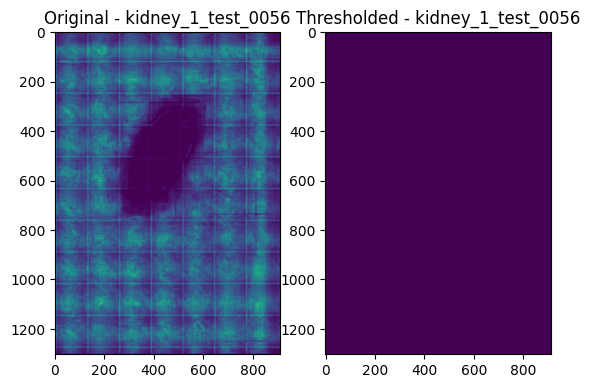

ValueError: If using all scalar values, you must pass an index

In [213]:
import re
debug = not is_submit
if debug:
    paths=["./kaggle/input/blood-vessel-segmentation/train/kidney_1_test"]
else:
    paths=glob("./kaggle/input/blood-vessel-segmentation/test/*")
TH = [output.flatten() for output in outputs] 
TH = np.concatenate(TH)
index = -int(len(TH) * CFG.th_percentile)
TH:int = np.partition(TH, index)[index]
print(TH)
submission_df = pd.DataFrame(columns=['id', 'rle'])

if debug:
    label_paths = ["./kaggle/input/blood-vessel-segmentation/train/kidney_1_test/images"]
else:
    label_paths = glob("./kaggle/input/blood-vessel-segmentation/test/*" + "/images")
# 列出文件夹中的所有文件，并进行排序，确保顺序与outputs一致
file_list = []
for label_path in label_paths:
    print(label_paths)
    kidney_id = re.split(r'[\\/]', label_path)[-2]
    print(kidney_id)
    file_names = sorted(os.listdir(label_path))
    for file_name in file_names:
        file_name = kidney_id + '_' + file_name
        print(file_name)
        file_list.append(file_name) 



print(file_list)


for idx, mask_pred in enumerate(outputs):
    # 获取id (例如：'kidney_1_test_label.png' -> 'kidney_1_test')
    print(idx)
    print(file_list)
    file_name = file_list[idx]  # idx 对应当前mask_pred的索引
    print(file_name)
    id = "_".join(file_name.split(".")[:-1])  # 移除文件扩展名部分

    # 如果有可视化需求
    if not is_submit:
        plt.subplot(121)
        plt.imshow(mask_pred)
        plt.title(f'Original - {id}')
        plt.subplot(122)
        plt.imshow(mask_pred>TH)
        plt.title(f'Thresholded - {id}')
        plt.show()

    # 应用阈值并执行RLE编码
    mask_pred_binary = mask_pred > TH
    rle = rle_encode(mask_pred_binary)
    
    # 将结果追加至submission_df
    submission_row = {'id': id, 'rle': rle}
    
    # 将新行追加到submission_df DataFrame
    submission_df = pd.concat([submission_df, pd.DataFrame(submission_row, index = [0])], axis=0, ignore_index=True)

Kaggle = False

if not Kaggle:
    submission_df.to_csv('./data/predictions/prediction' + current_date +'-'+ current_time+ '.csv', index=False)
if Kaggle:
    submission_df.to_csv('submission.csv', index=False)